In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

# 1D operator apply to 2D data
Only advect over x or y direction.

In [2]:
def upwind_tendency_1d(c, u, dx, dt, dim=0):
    '''
    Tensorflow vectorized version of advection tendency with periodic boundary.
    Use first-order, upwind approximation
    
    Works for both 1D and 2D data.
    In 2D case, only do one dimension specified by `dim`. 
    Need to apply over both dimensions to get a true 2D solver (see `vanleer_tendency_2d()`). 

    Args:
      c: 1d or 2d Tensor, density field
      u: 1d or 2d Tensor, wind field
      dx: 0d Tensor, grid spacing (assume uniform)
      dt: 0d Tensor, time step
      dim: int, dimension of advection. In 1D, always be 0; in 2D, use 0 for y dimension and 1 for x dimension

    Returns:
      1d or 2d Tensor with same shape as `c`
    '''
    
    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    u = 0.5*(u+tf.manip.roll(u, 1, dim))

    c_l = tf.manip.roll(c, 1, dim)  # so c_l[i] == c[i-1], with periodic boundary
            
    flux_right = tf.maximum(u, 0) * c_l
    flux_left = tf.minimum(u, 0) * c
    flux = flux_right + flux_left
            
    tendency = flux - tf.manip.roll(flux, -1, dim)
    
    return tendency*dt/dx

In [3]:
def vanleer_tendency_1d(c, u, dx, dt, dim=0):
    '''
    Tensorflow vectorized version of advection tendency with periodic boundary.
    Use second-order, piece-wise linear approximation with VanLeer flux-limiter.
    
    Works for both 1D and 2D data.
    In 2D case, only do one dimension specified by `dim`. 
    Need to apply over both dimensions to get a true 2D solver (see `vanleer_tendency_2d()`). 

    Args:
      c: 1d or 2d Tensor, density field
      u: 1d or 2d Tensor, wind field
      dx: 0d Tensor, grid spacing (assume uniform)
      dt: 0d Tensor, time step
      dim: int, dimension of advection. In 1D, always be 0; in 2D, use 0 for y dimension and 1 for x dimension

    Returns:
      1d or 2d Tensor with same shape as `c`
    '''
    
    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    u = 0.5*(u+tf.manip.roll(u, 1, dim))
    
    c_l = tf.manip.roll(c, 1, dim)
    c_r = tf.manip.roll(c, -1, dim)
    
    delta = c - c_l
    delta_avg = (delta + tf.manip.roll(delta, -1, dim))/2
            
    # can also use np.maximum.reduce()
    c_max = tf.maximum(c, tf.maximum(c_l, c_r)) # upper boundary
    c_min = tf.minimum(c, tf.minimum(c_l, c_r)) # lower boundary
    mismatch = tf.sign(delta_avg)*tf.minimum(tf.abs(delta_avg), tf.minimum(2*(c-c_min), 2*(c_max-c)))
        
    # compute flux from slope
    mismatch_l = tf.manip.roll(mismatch, 1, dim)

    cfl = u*dt/dx
    flux_right = tf.maximum(u, 0) * (c_l + mismatch_l*(1-cfl)/2)
    flux_left = tf.minimum(u, 0) * (c - mismatch*(1+cfl)/2)
    flux = flux_right + flux_left
    
    tendency = flux - tf.manip.roll(flux, -1, dim)
    
    return tendency*dt/dx

In [4]:
nx = 100
ny = 100
Lx = 1
Ly = 1
dx = Lx/nx
dy = Ly/ny
dt = 0.01
nt = 100

u = np.ones([nx, ny]) * 0.5 
v = np.ones([nx, ny]) * 0.3

c0 = np.zeros([nx, ny])

c0[int(ny*0.2):int(ny*0.4), int(nx*0.1):int(nx*0.3)] = 1.0  # 2D square

In [5]:
%%time

u_tensor = tf.convert_to_tensor(u)
c_tensor = tf.convert_to_tensor(c0)

nt = 50

c_tensor = tf.convert_to_tensor(c0)
for _ in range(nt):
    c_tensor += vanleer_tendency_1d(c_tensor, u_tensor, dx, dt, dim=1)

CPU times: user 75.6 ms, sys: 12.7 ms, total: 88.3 ms
Wall time: 66.8 ms


Text(0.5,1,'initial condition')

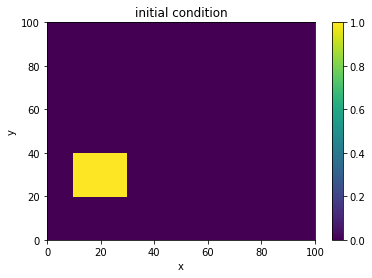

In [6]:
plt.pcolormesh(c0)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('initial condition')

Text(0.5,1,'Second-order (Van-Leer)')

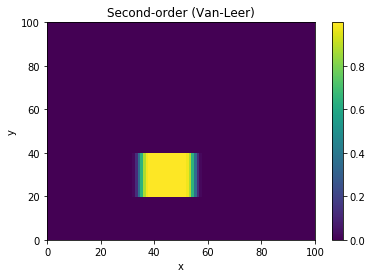

In [7]:
plt.pcolormesh(c_tensor.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Second-order (Van-Leer)')

# True 2D operator by combing 1D operators

In [8]:
def vanleer_tendency_2d(c, u, v, dx, dy, dt):
    '''
    2D advection tendency with periodic boundary
    Use second-order (VanLeer) scheme for outer operator and upwind for inner operator

    Args:
      c: 2d Tensor, density field
      u: 2d Tensor, wind field in x direction
      v: 2d Tensor, wind field in y direction
      dx: 0d Tensor, grid spacing (assume uniform)
      dy: 0d Tensor, grid spacing (assume uniform, but can be different from dx)
      dt: 0d Tensor, time step

    Returns:
      2d Tensor with same shape as `c`
    '''

    # operator splitting in x and y directions
    tendency = (vanleer_tendency_1d(0.5*upwind_tendency_1d(c, v, dy, dt, dim=0) + c, u, dx, dt, dim=1) +
                vanleer_tendency_1d(0.5*upwind_tendency_1d(c, u, dx, dt, dim=1) + c, v, dy, dt, dim=0)
                )

    return tendency

In [9]:
%%time
# second time will be much faster (due to jit)
c_tensor = tf.convert_to_tensor(c0)

nt = 100

for _ in range(nt):
    c_tensor += vanleer_tendency_2d(c_tensor, u, v, dx, dy, dt)
    
# only 50% slower than numba version (see below), much better than in 1D case!

CPU times: user 342 ms, sys: 34.2 ms, total: 376 ms
Wall time: 312 ms


Text(0.5,1,'Second-order (Van-Leer)')

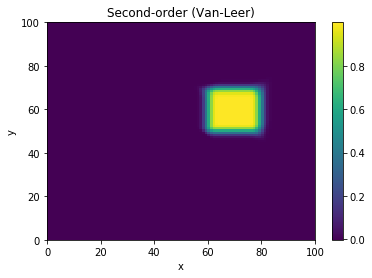

In [10]:
plt.pcolormesh(c_tensor.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Second-order (Van-Leer)')

## Compare with numpy version

In [11]:
from advection_solver.advection_2d import tendency_2d_vanleer

In [13]:
%%time
# second time will be much faster (due to jit)
nt = 100
c = c0.copy()
for _ in range(nt):
    c += tendency_2d_vanleer(c, u, v, dx, dy, dt)

CPU times: user 191 ms, sys: 3.19 ms, total: 194 ms
Wall time: 193 ms


In [14]:
np.allclose(c_tensor.numpy(), c)

True